# Assignment 1 #

We are given three columns of integers with a row for each node. The first two columns contain x and y coordinates of the node positions in a plane. The third column contains node costs. The goal is to select exactly 50% of the nodes (if the number of nodes is odd we round the number of nodes to be selected up) and form a Hamiltonian cycle (closed path) through this set of nodes such that the sum of the total length of the path plus the total cost of the selected nodes is minimized. The distances between nodes are calculated as Euclidean distances rounded mathematically to integer values. The distance matrix should be calculated just after reading an instance and then only the distance matrix (no nodes coordinates) should be accessed by optimization methods to allow instances defined only by distance matrices. 

## Read the data ##

In [32]:
import pandas as pd
import numpy as np
from numpy.typing import ArrayLike, NDArray
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import random
from tqdm import tqdm
from math import sqrt

In [40]:
# read data into dataframes
instances = {
    "A": pd.read_csv("data/TSPA.csv", sep=';', header=None, names=["x", "y", "cost"]),
    "B": pd.read_csv("data/TSPB.csv", sep=';', header=None, names=["x", "y", "cost"]),
    "C": pd.read_csv("data/TSPC.csv", sep=';', header=None, names=["x", "y", "cost"]),
    "D": pd.read_csv("data/TSPD.csv", sep=';', header=None, names=["x", "y", "cost"]),
}

In [41]:
def calculate_distance_matrix(df: pd.DataFrame) -> NDArray[np.int32]:
    """
    Calculate the distance matrix from the dataframe.
    The dataframe contains 'x' and 'y' columns for the coordinates.
    The distances are Euclidean, rounded to the nearest integer + the cost of the destination node.
    """
    coordinates = df[['x', 'y']].to_numpy()
    costs = df["cost"].to_numpy()
    dist_matrix = np.zeros(shape=(len(df), len(df)))
    for i in range(len(coordinates)):
        for j in range(len(coordinates)):
            dist_matrix[i, j] = round(sqrt((coordinates[i, 0] - coordinates[j, 0])**2 + (coordinates[i, 1] - coordinates[j, 1])**2)) + costs[j]
    return dist_matrix

In [ ]:
    # coordinates = df[['x', 'y']].to_numpy()
    # dist_matrix = distance_matrix(coordinates, coordinates)
    # dist_matrix = np.round(dist_matrix).astype(int)

In [38]:
test = pd.DataFrame({
    "x": [1,3,5,6.5,7,9,9.5,10],
    "y": [5,8,1,6.5,4,7,1,4.5],
    "cost": [2,3,1,2,4,6,0,2]
})

In [39]:
calculate_distance_matrix(test)

array([[ 2.,  7.,  7.,  8., 10., 14.,  9., 11.],
       [ 6.,  3.,  8.,  6., 10., 12., 10., 10.],
       [ 8., 10.,  1.,  8.,  8., 13.,  4.,  8.],
       [ 8.,  7.,  7.,  2.,  7.,  9.,  6.,  6.],
       [ 8.,  9.,  5.,  5.,  4., 10.,  4.,  5.],
       [10.,  9.,  8.,  5.,  8.,  6.,  6.,  5.],
       [11., 13.,  5.,  8.,  8., 12.,  0.,  6.],
       [11., 11.,  7.,  6.,  7.,  9.,  4.,  2.]])

In [42]:
distances_matrices = {
    "A": calculate_distance_matrix(instances["A"]),
    "B": calculate_distance_matrix(instances["B"]),
    "C": calculate_distance_matrix(instances["C"]),
    "D": calculate_distance_matrix(instances["D"])
}

costs = {
    "A": instances["A"]["cost"].to_numpy(),
    "B": instances["B"]["cost"].to_numpy(),
    "C": instances["C"]["cost"].to_numpy(),
    "D": instances["D"]["cost"].to_numpy()
}

In [5]:
def total_cost(selected_nodes, costs):
    """Calculate the total cost for the selected nodes."""
    return sum(costs[node] for node in selected_nodes)

In [43]:
def visualize_selected_route(
    selected_nodes_indices: ArrayLike, 
    dataframe: pd.DataFrame,
    title: str) -> None:
    """
    Visualize the selected route returned by the algorithm, including the cost of each node represented by a colormap.

    Parameters:
    selected_nodes_indices (list): Indices of the selected nodes in the route.
    dataframe (DataFrame): DataFrame containing 'x', 'y', and 'cost' columns for each node.
    """
    x = dataframe.loc[selected_nodes_indices, 'x']
    y = dataframe.loc[selected_nodes_indices, 'y']
    costs = dataframe.loc[selected_nodes_indices, 'cost']

    cmap = plt.cm.get_cmap('viridis')
    norm = plt.Normalize(vmin=min(costs), vmax=max(costs))

    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(x, y, c=costs, cmap=cmap, norm=norm, s=100)
    plt.colorbar(scatter, label='Node Cost')

    for i, node in enumerate(selected_nodes_indices):
        start_node = selected_nodes_indices[i]
        end_node = selected_nodes_indices[(i + 1) % len(selected_nodes_indices)]
        plt.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'k-', lw=1)

    plt.title(title, fontsize=18)
    plt.xlabel('X Coordinate', fontsize=14)
    plt.ylabel('Y Coordinate', fontsize=14)
    plt.grid(True)
    plt.show()

## Random solution ##

### The algorithm

In [7]:
def generate_random_solution(
    dist_matrix: NDArray[np.int32], 
    costs: np.array
    ) -> tuple[ArrayLike, int]:
    """Generate a random solution to the problem

    Parameters
    ----------
    dist_matrix : NDArray[np.int32]
        distance matrix of the instance
    costs : np.array
        costs of the nodes

    Returns
    -------
    tuple[ArrayLike, int]
        tuple of the selected nodes and the total cost
    """
    num_nodes = dist_matrix.shape[0]
    num_select = (num_nodes + 1) // 2  # round up if odd
    selected_nodes = random.sample(range(num_nodes), num_select)
    random.shuffle(selected_nodes)
    total_distance = sum(
        dist_matrix[selected_nodes[i], selected_nodes[i - 1]] 
        for i in range(num_select)
    )
    # Add the distance between the last and the first node.
    total_distance += dist_matrix[selected_nodes[0], selected_nodes[-1]]
    # Compute the total cost of the selected nodes.
    total_nodes_cost = total_cost(selected_nodes, costs)
    return selected_nodes, total_distance + total_nodes_cost

### Running the method ###

In [8]:
num_solutions = 200
random_solutions = {
    "A": [generate_random_solution(distances_matrices["A"], costs["A"]) for _ in tqdm(range(num_solutions))],
    "B": [generate_random_solution(distances_matrices["B"], costs["B"]) for _ in tqdm(range(num_solutions))],
    "C": [generate_random_solution(distances_matrices["C"], costs["C"]) for _ in tqdm(range(num_solutions))],
    "D": [generate_random_solution(distances_matrices["D"], costs["D"]) for _ in tqdm(range(num_solutions))]
}

objectives_values = {
    "A": [solution[1] for solution in random_solutions["A"]],
    "B": [solution[1] for solution in random_solutions["B"]],
    "C": [solution[1] for solution in random_solutions["C"]],
    "D": [solution[1] for solution in random_solutions["D"]]
}

selected_nodes = {
    "A": [solution[0] for solution in random_solutions["A"]],
    "B": [solution[0] for solution in random_solutions["B"]],
    "C": [solution[0] for solution in random_solutions["C"]],
    "D": [solution[0] for solution in random_solutions["D"]]
}

100%|██████████| 200/200 [00:00<00:00, 7383.56it/s]

In [9]:
for instance in objectives_values:
    print(f"Instance {instance} - min: {min(objectives_values[instance])}, max: {max(objectives_values[instance])}, mean: {np.mean(objectives_values[instance])}")

Instance A - min: 242575, max: 293014, mean: 265048.48
Instance B - min: 244632, max: 294388, mean: 269084.195
Instance C - min: 192697, max: 240334, mean: 216266.5
Instance D - min: 199976, max: 243755, mean: 220852.98


#### Instance A - best solution ###

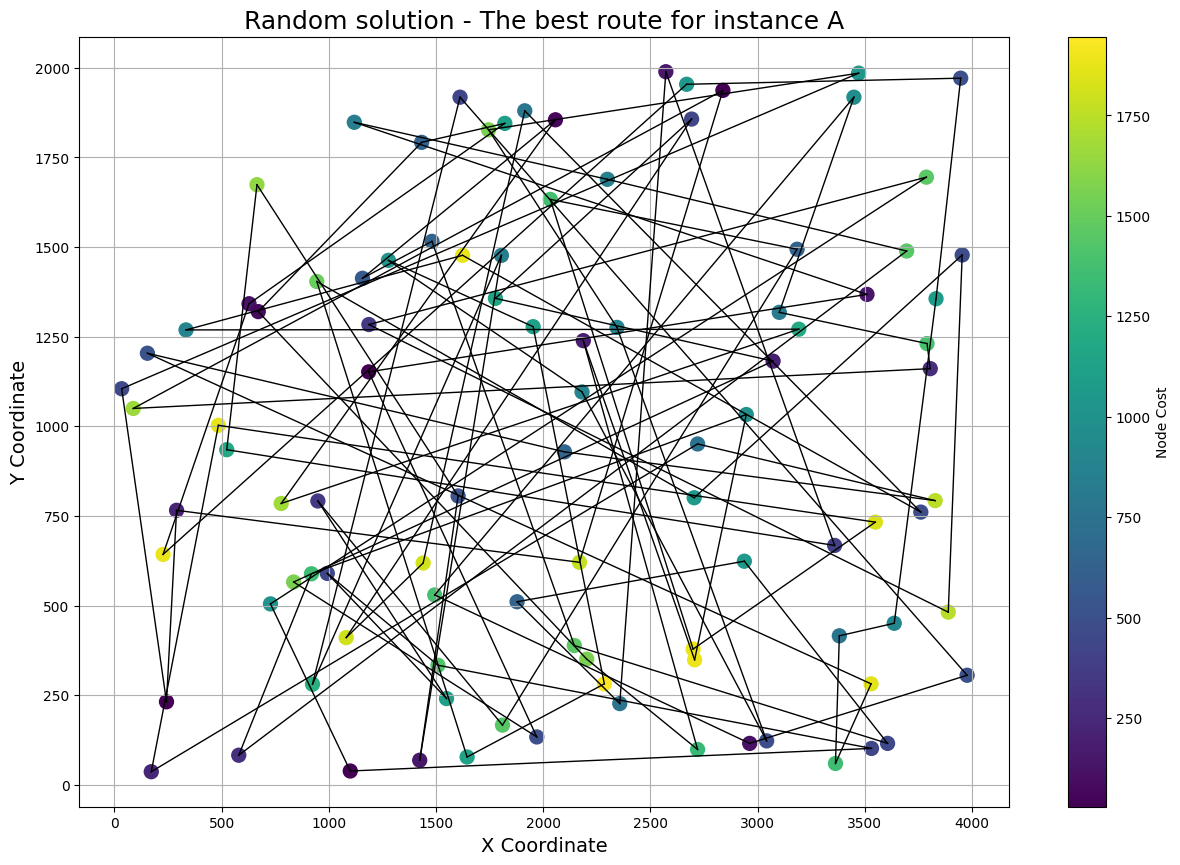

In [10]:
best_A_solution = random_solutions["A"][np.argmin(objectives_values["A"])]

visualize_selected_route(best_A_solution[0], instances["A"], "Random solution - The best route for instance A")

#### Instance B - best solution ####

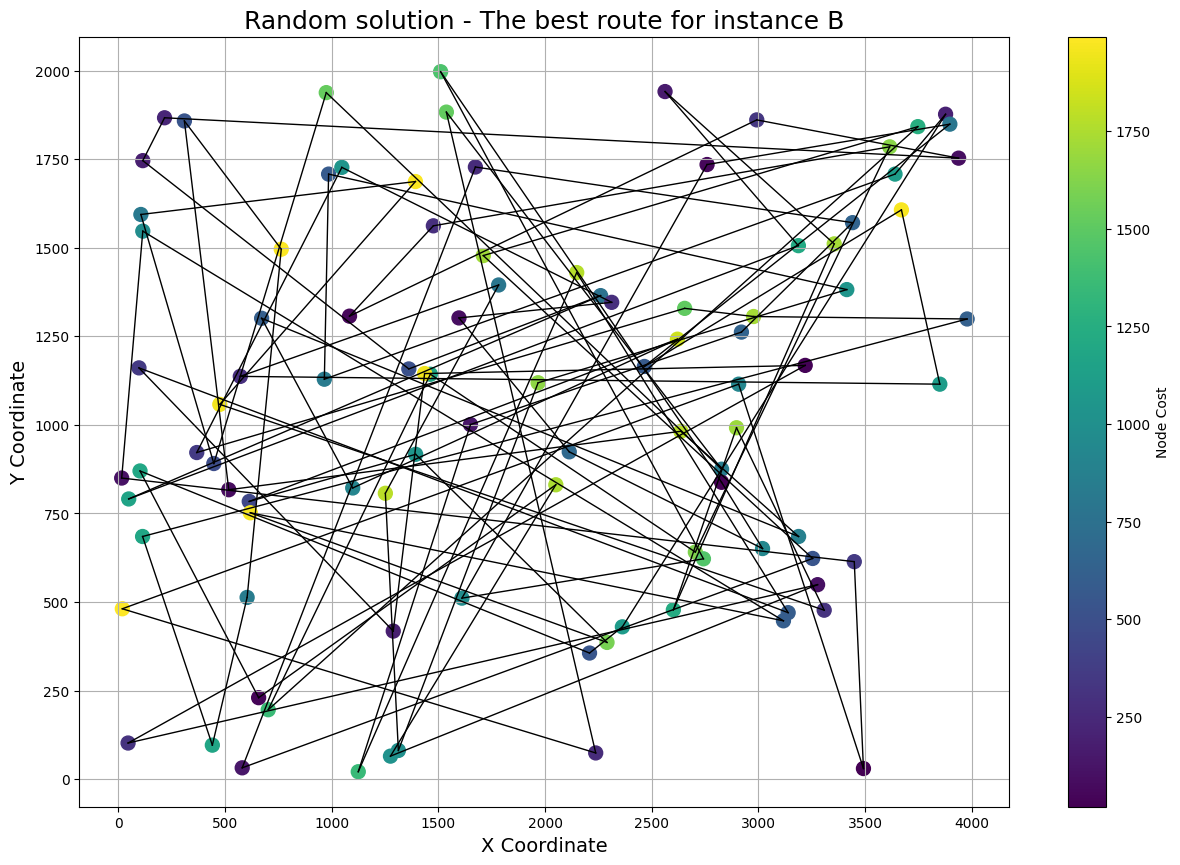

In [11]:
best_B_solution = random_solutions["B"][np.argmin(objectives_values["B"])]
visualize_selected_route(best_B_solution[0], instances["B"], "Random solution - The best route for instance B")

#### Instance C - best solution

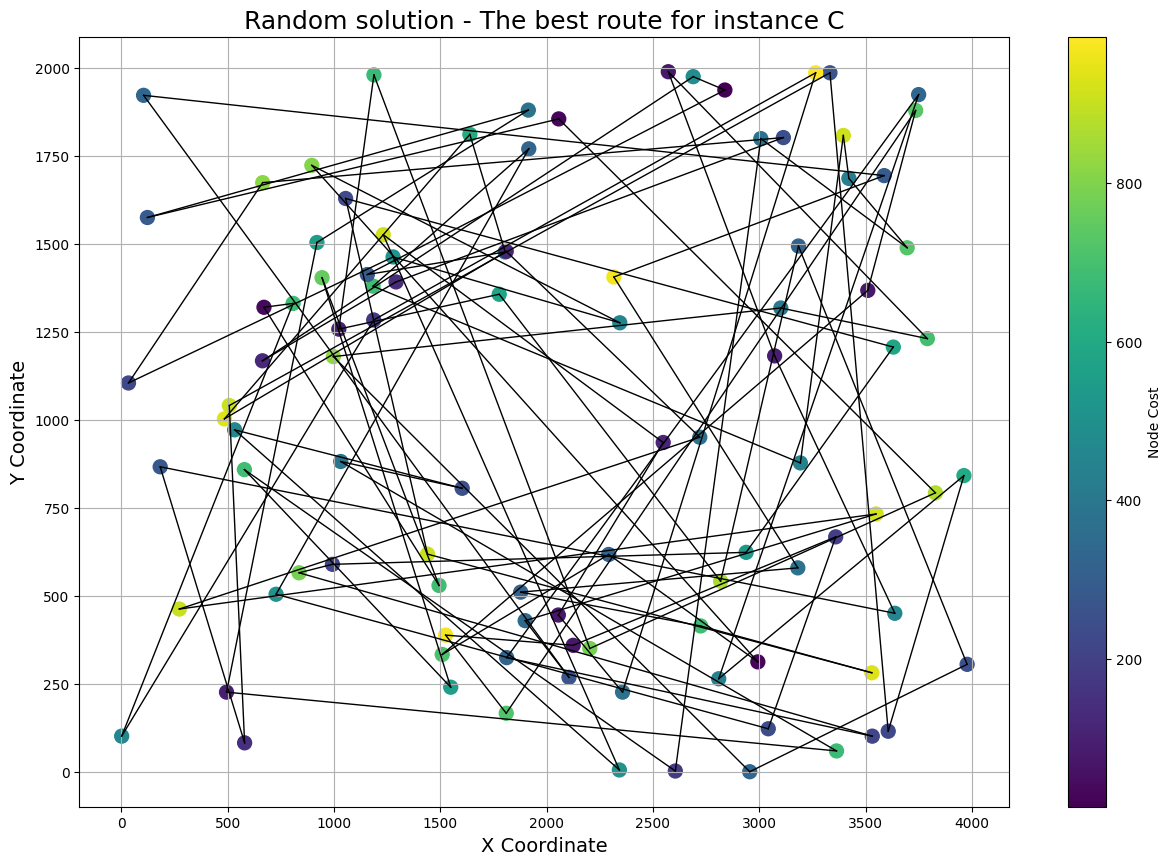

In [12]:
best_C_solution = random_solutions["C"][np.argmin(objectives_values["C"])]
visualize_selected_route(best_C_solution[0], instances["C"], "Random solution - The best route for instance C")

#### Instance D - best solution ####

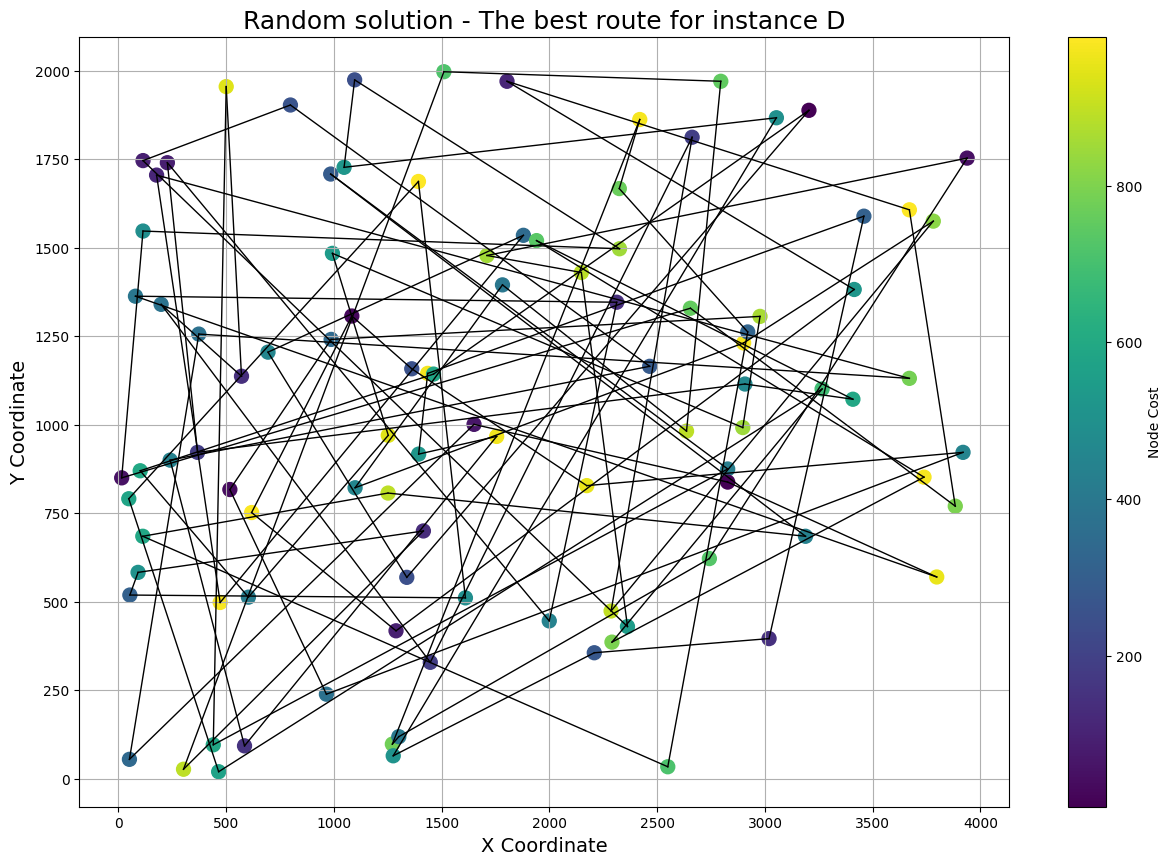

In [13]:
best_D_solution = random_solutions["D"][np.argmin(objectives_values["D"])]
visualize_selected_route(best_D_solution[0], instances["D"], "Random solution - The best route for instance D")

## Nearest Neighbor ##

### The algorithm ###

In [44]:
def generate_nearest_neighbor_solution(dist_matrix, costs, start_node):
    """
    Generate a solution using the nearest neighbor heuristic.
    Starts from the 'start_node' and repeatedly selects the nearest unselected node.
    """
    num_nodes = dist_matrix.shape[0]
    num_select = (num_nodes + 1) // 2

    selected_nodes = [start_node]    
    unselected_nodes = set(range(num_nodes)) - {start_node}
    total_distance = 0
    while len(selected_nodes) < num_select:
        last_node = selected_nodes[-1]
        nearest_node = min(
            unselected_nodes, 
            key=lambda node: dist_matrix[last_node, node]
        )
        selected_nodes.append(nearest_node)
        unselected_nodes.remove(nearest_node)
        total_distance += dist_matrix[last_node, nearest_node]

    total_distance += dist_matrix[selected_nodes[-1], selected_nodes[0]]
    # cost = total_cost(selected_nodes, costs)

    return selected_nodes, total_distance

### Running the method ###

In [45]:
num_solutions = 200
nn_solutions = {
    "A": [generate_nearest_neighbor_solution(distances_matrices["A"], costs["A"], start_node=start_node) for start_node in tqdm(range(num_solutions))],
    "B": [generate_nearest_neighbor_solution(distances_matrices["B"], costs["B"], start_node=start_node) for start_node in tqdm(range(num_solutions))],
    "C": [generate_nearest_neighbor_solution(distances_matrices["C"], costs["C"], start_node=start_node) for start_node in tqdm(range(num_solutions))],
    "D": [generate_nearest_neighbor_solution(distances_matrices["D"], costs["D"], start_node=start_node) for start_node in tqdm(range(num_solutions))]
}

nn_objectives_values = {
    "A": [solution[1] for solution in nn_solutions["A"]],
    "B": [solution[1] for solution in nn_solutions["B"]],
    "C": [solution[1] for solution in nn_solutions["C"]],
    "D": [solution[1] for solution in nn_solutions["D"]]
}

nn_selected_nodes = {
    "A": [solution[0] for solution in nn_solutions["A"]],
    "B": [solution[0] for solution in nn_solutions["B"]],
    "C": [solution[0] for solution in nn_solutions["C"]],
    "D": [solution[0] for solution in nn_solutions["D"]]
}

100%|██████████| 200/200 [00:00<00:00, 351.22it/s]


In [46]:
for instance in nn_objectives_values:
    print(f"Instance {instance} - min: {min(nn_objectives_values[instance])}, max: {max(nn_objectives_values[instance])}, mean: {np.mean(nn_objectives_values[instance])}")

Instance A - min: 84471.0, max: 95013.0, mean: 87679.135
Instance B - min: 77448.0, max: 82631.0, mean: 79282.58
Instance C - min: 56304.0, max: 63697.0, mean: 58872.68
Instance D - min: 50335.0, max: 59846.0, mean: 54290.68


#### Instance A - best solution ####

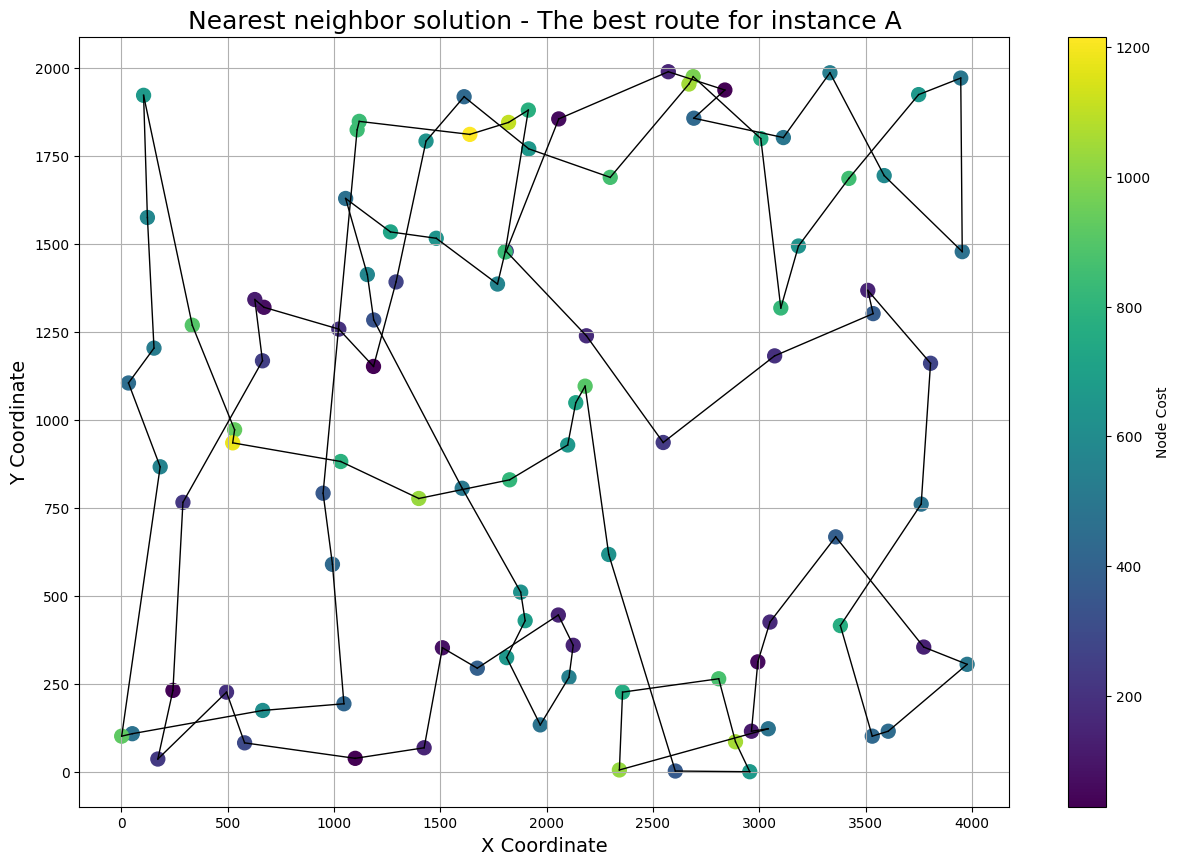

In [47]:
nn_best_A_solution = nn_solutions["A"][np.argmin(nn_objectives_values["A"])]
visualize_selected_route(nn_best_A_solution[0], instances["A"], "Nearest neighbor solution - The best route for instance A")

#### Instance B - best solution ####

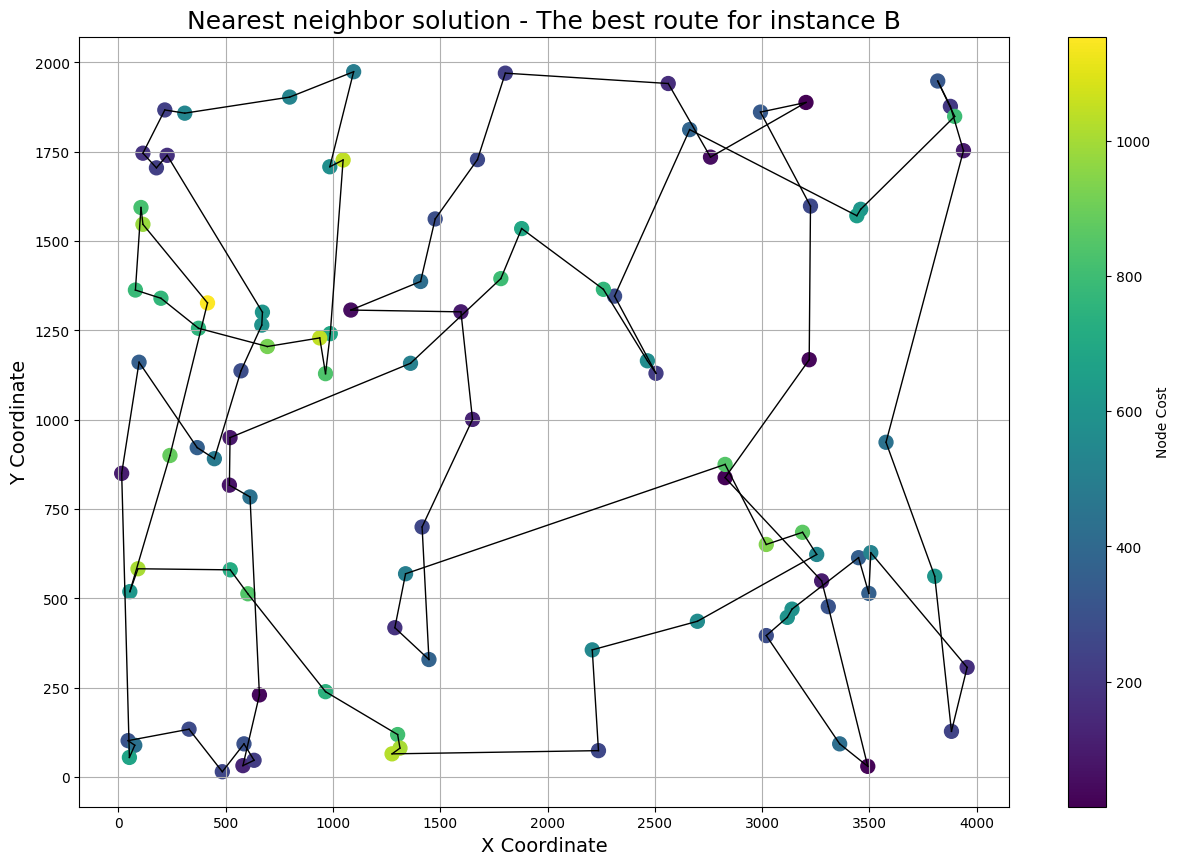

In [48]:
nn_best_B_solution = nn_solutions["B"][np.argmin(nn_objectives_values["B"])]
visualize_selected_route(nn_best_B_solution[0], instances["B"], "Nearest neighbor solution - The best route for instance B")

#### Instance C - best solution ####

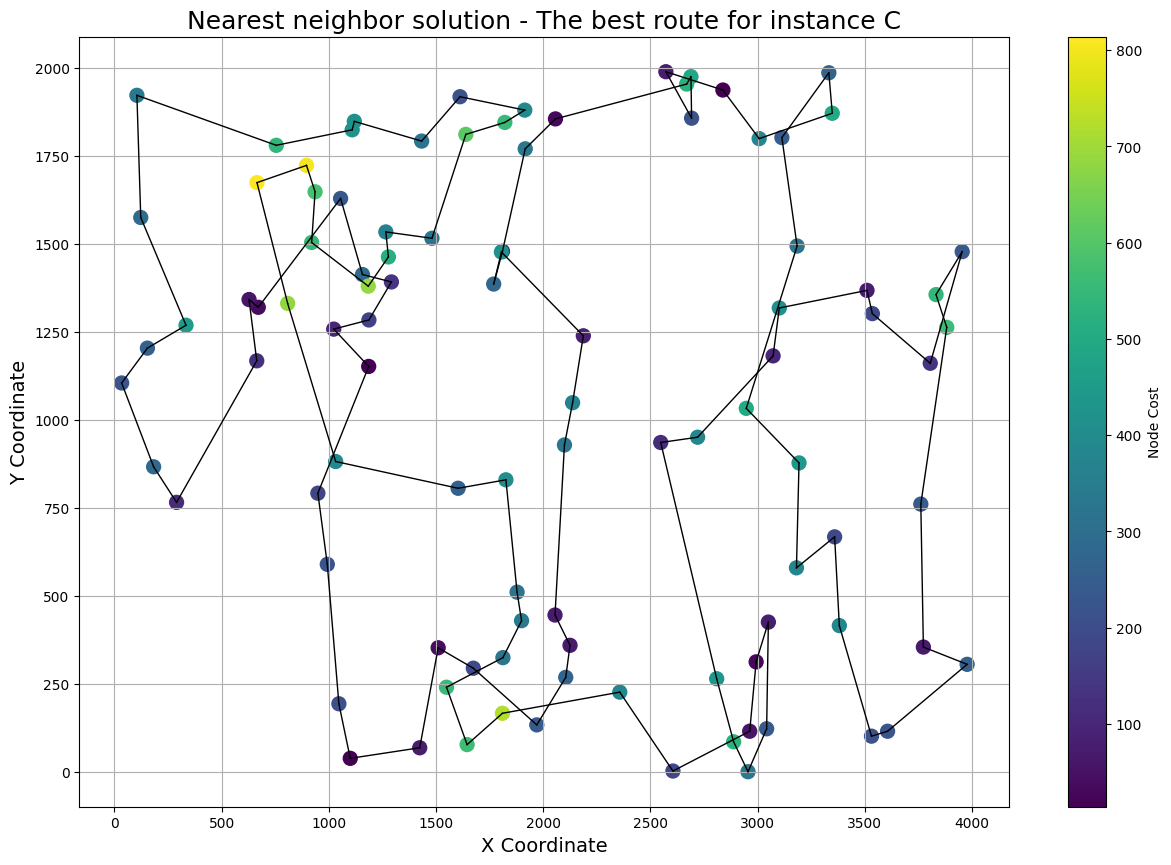

In [49]:
nn_best_C_solution = nn_solutions["C"][np.argmin(nn_objectives_values["C"])]
visualize_selected_route(nn_best_C_solution[0], instances["C"], "Nearest neighbor solution - The best route for instance C")

#### Instance D - best solution ####

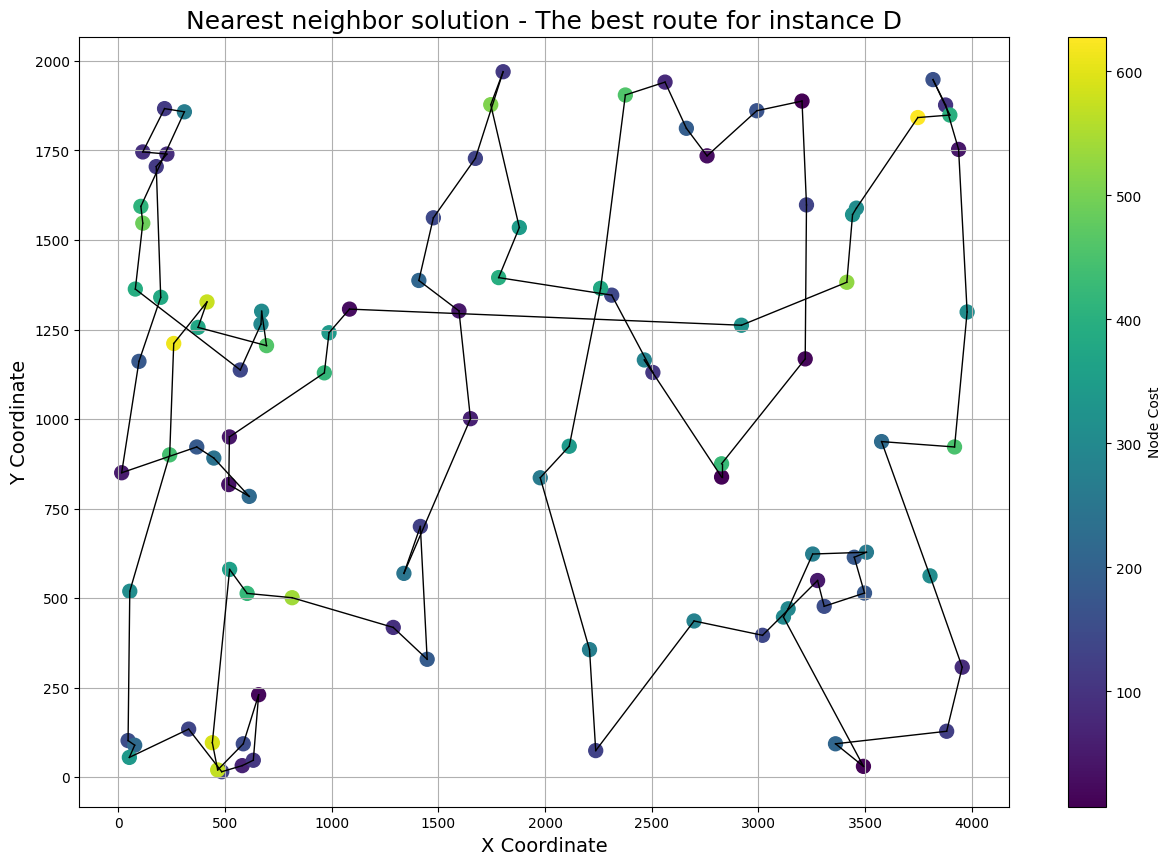

In [50]:
nn_best_D_solution = nn_solutions["D"][np.argmin(nn_objectives_values["D"])]
visualize_selected_route(nn_best_D_solution[0], instances["D"], "Nearest neighbor solution - The best route for instance D")

## Greedy cycle

# The algorithm

In [69]:
def generate_greedy_cycle(dist_matrix, start_node):
    num_nodes = dist_matrix.shape[0]
    num_select = (num_nodes + 1) // 2  # Selecting 50% of the nodes

    # Initialize the cycle with the start_node
    selected_nodes = [start_node]
    unselected_nodes = set(range(num_nodes)) - {start_node}

    # Initialize the total distance to 0
    total_distance = 0

    # Continue until we've selected the required number of nodes
    while len(selected_nodes) < num_select:
        min_increase = float('inf')
        best_node = None
        best_position = None

        # Evaluate the insertion of each unselected node
        for node in unselected_nodes:
            # Try inserting between each pair of consecutive nodes in the cycle
            for i in range(len(selected_nodes)):
                # Calculate the increase in distance
                next_i = (i + 1) % len(selected_nodes)
                increase = (dist_matrix[selected_nodes[i], node] +
                            dist_matrix[node, selected_nodes[next_i]] -
                            dist_matrix[selected_nodes[i], selected_nodes[next_i]])
                
                # Check if this is the best option so far
                if increase < min_increase:
                    min_increase = increase
                    best_node = node
                    best_position = next_i  # Insert before next_i

        # Insert the best node into the cycle
        selected_nodes.insert(best_position, best_node)
        unselected_nodes.remove(best_node)
        total_distance += min_increase

    # Complete the cycle
    total_distance += dist_matrix[selected_nodes[-1], selected_nodes[0]]

    return selected_nodes, total_distance

In [72]:
num_solutions = 200
cycle_solutions = {
    "A": [generate_greedy_cycle(distances_matrices["A"], start_node=start_node) for start_node in tqdm(range(num_solutions))],
    "B": [generate_greedy_cycle(distances_matrices["B"], start_node=start_node) for start_node in tqdm(range(num_solutions))],
    "C": [generate_greedy_cycle(distances_matrices["C"], start_node=start_node) for start_node in tqdm(range(num_solutions))],
    "D": [generate_greedy_cycle(distances_matrices["D"], start_node=start_node) for start_node in tqdm(range(num_solutions))]
}

cycle_objectives_values = {
    "A": [solution[1] for solution in cycle_solutions["A"]],
    "B": [solution[1] for solution in cycle_solutions["B"]],
    "C": [solution[1] for solution in cycle_solutions["C"]],
    "D": [solution[1] for solution in cycle_solutions["D"]]
}

cycle_selected_nodes = {
    "A": [solution[0] for solution in cycle_solutions["A"]],
    "B": [solution[0] for solution in cycle_solutions["B"]],
    "C": [solution[0] for solution in cycle_solutions["C"]],
    "D": [solution[0] for solution in cycle_solutions["D"]]
}

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [01:32<00:00,  2.15it/s]


In [73]:
for instance in cycle_objectives_values:
    print(f"Instance {instance} - min: {min(cycle_objectives_values[instance])}, max: {max(cycle_objectives_values[instance])}, mean: {np.mean(cycle_objectives_values[instance])}")

Instance A - min: 75136.0, max: 80025.0, mean: 76711.185
Instance B - min: 67896.0, max: 76096.0, mean: 70464.265
Instance C - min: 53020.0, max: 58499.0, mean: 55859.31
Instance D - min: 50288.0, max: 60208.0, mean: 54931.05


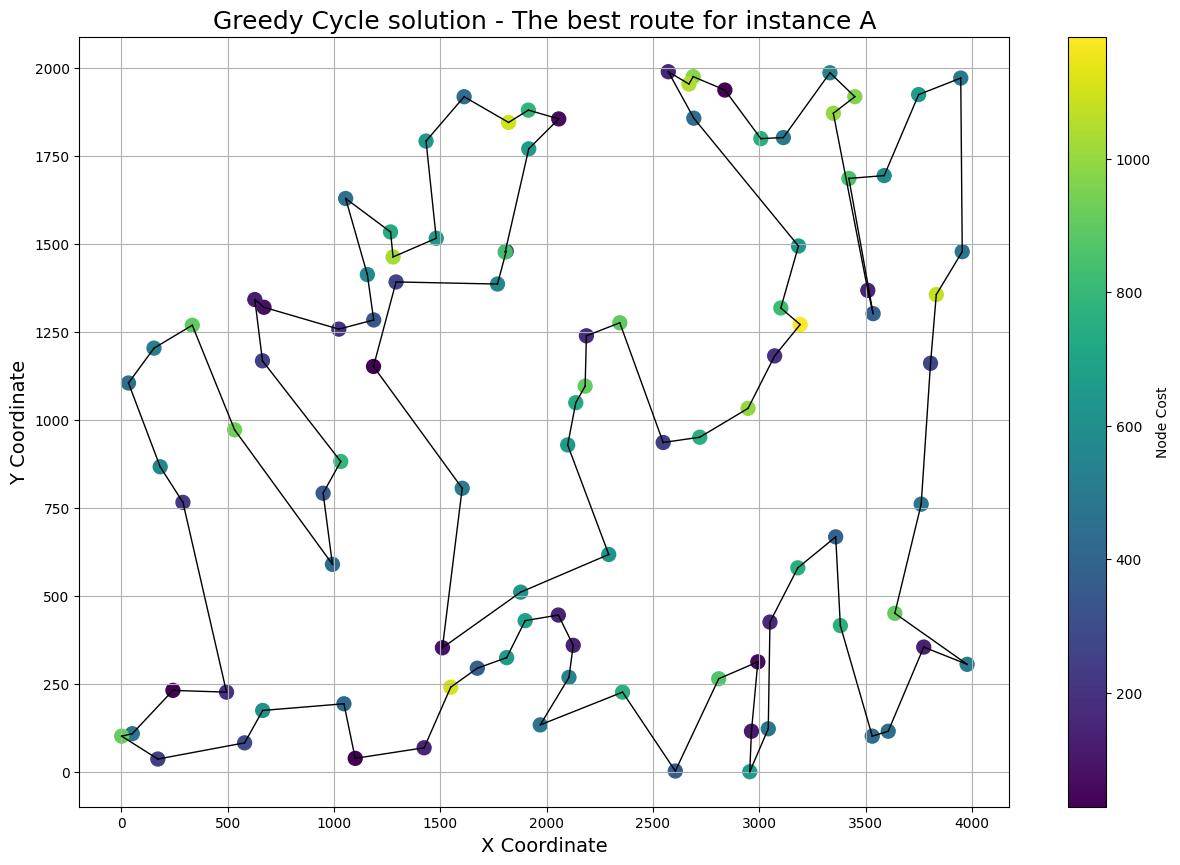

In [74]:
cycle_best_A_solution = cycle_solutions["A"][np.argmin(cycle_objectives_values["A"])]
visualize_selected_route(cycle_best_A_solution[0], instances["A"], "Greedy Cycle solution - The best route for instance A")

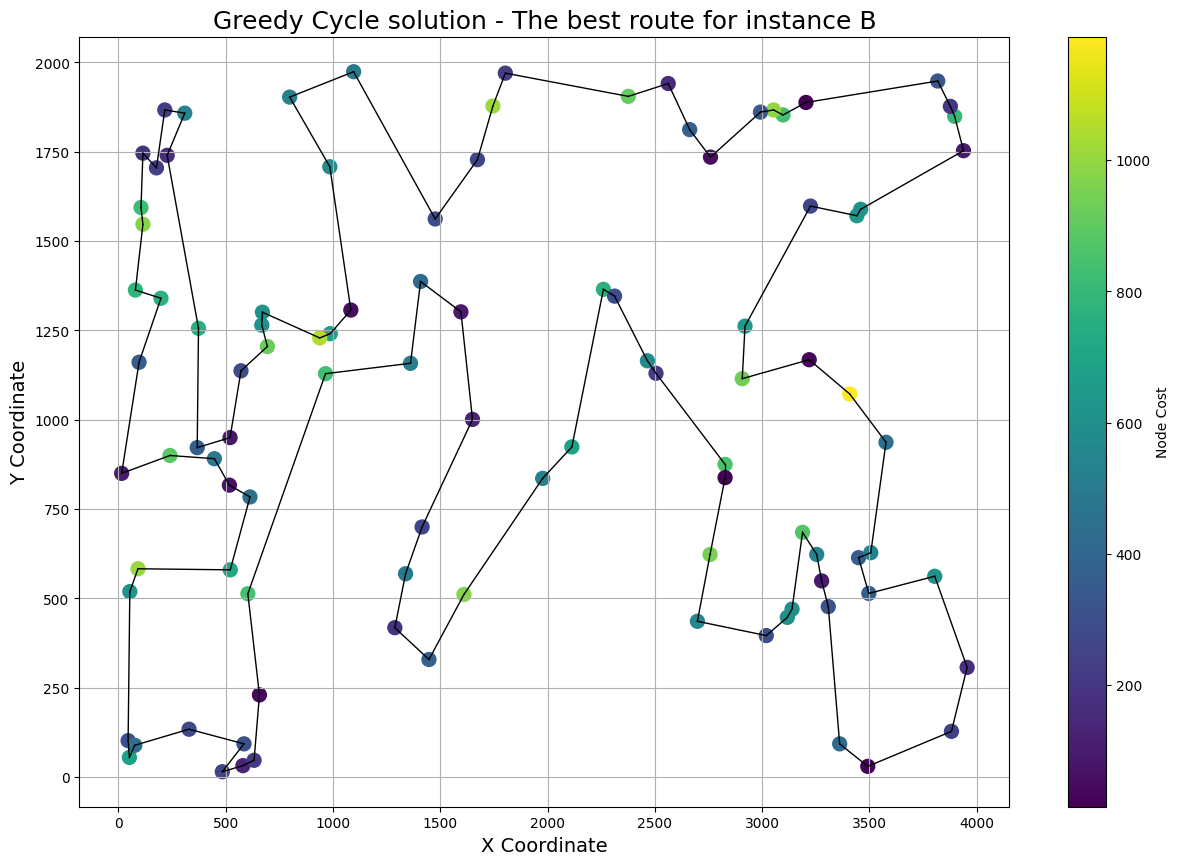

In [75]:
cycle_best_A_solution = cycle_solutions["B"][np.argmin(cycle_objectives_values["B"])]
visualize_selected_route(cycle_best_A_solution[0], instances["B"], "Greedy Cycle solution - The best route for instance B")

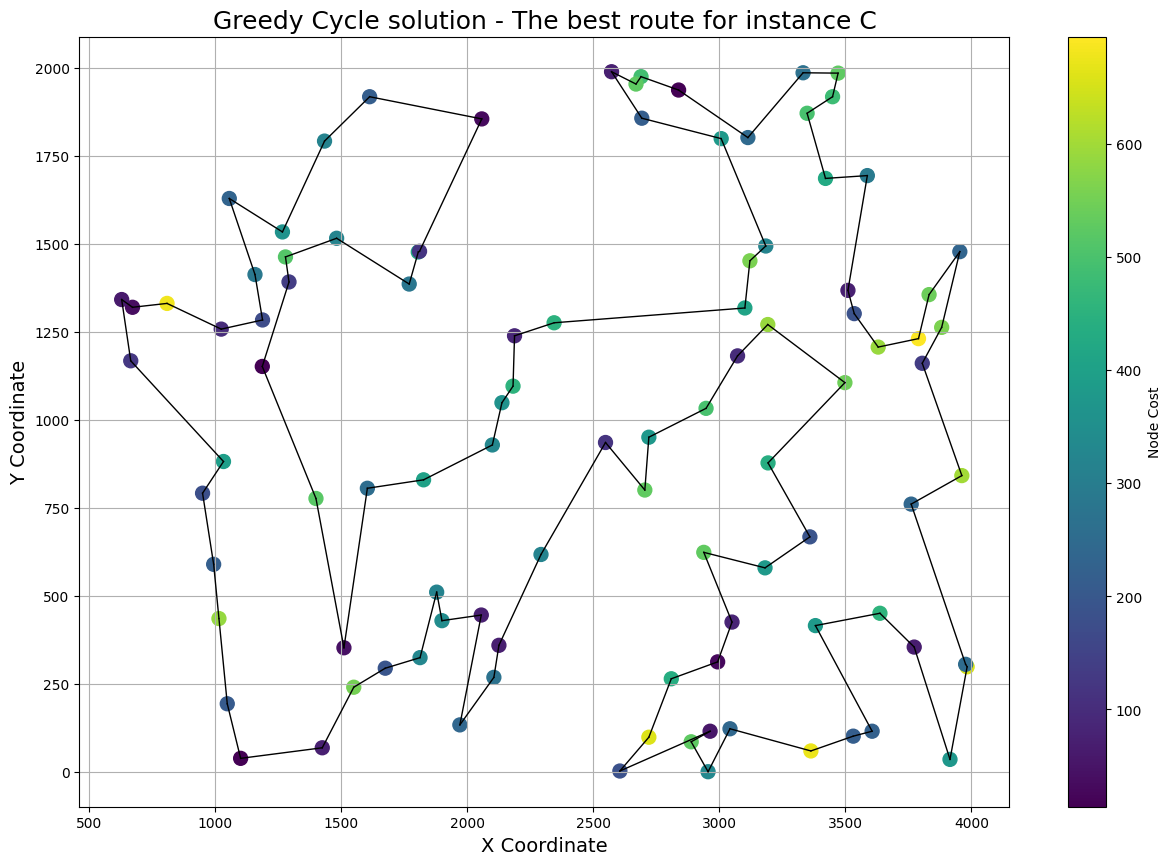

In [76]:
cycle_best_A_solution = cycle_solutions["C"][np.argmin(cycle_objectives_values["C"])]
visualize_selected_route(cycle_best_A_solution[0], instances["C"], "Greedy Cycle solution - The best route for instance C")

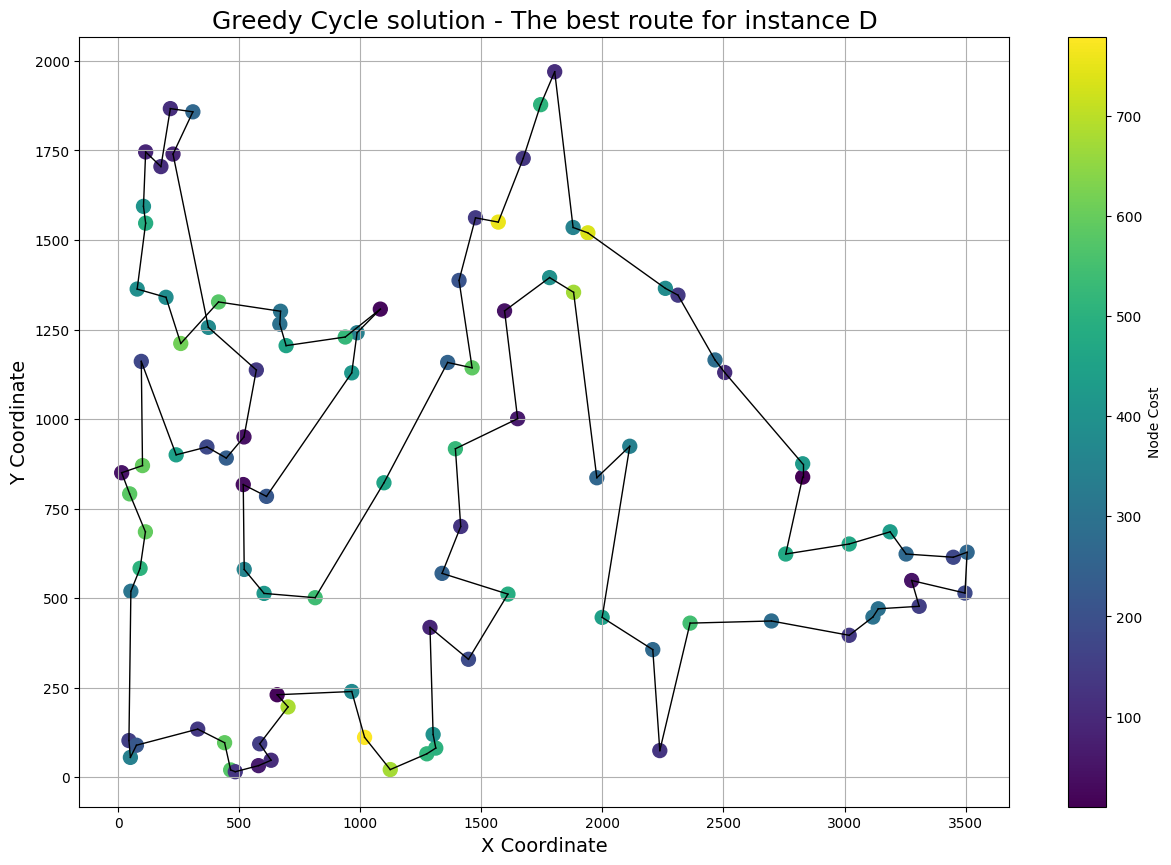

In [77]:
cycle_best_A_solution = cycle_solutions["D"][np.argmin(cycle_objectives_values["D"])]
visualize_selected_route(cycle_best_A_solution[0], instances["D"], "Greedy Cycle solution - The best route for instance D")